In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/MyDrive/DL/traffic_Data/DATA'
import pandas as pd
labels_df = pd.read_csv('/content/drive/MyDrive/DL/labels.csv')

In [5]:
import os
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

In [6]:
images = []
labels = []

In [7]:
for class_folder in os.listdir(data_dir):
    class_id = int(class_folder)
    class_path = os.path.join(data_dir, class_folder)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        class_name = labels_df.loc[labels_df['ClassId'] == class_id, 'Name'].iloc[0]
        labels.append(class_name)

In [8]:
max_height = max(img.shape[0] for img in images)
max_width = max(img.shape[1] for img in images)


In [9]:
resized_images = []
for img in images:
    resized_img = cv2.resize(img, (224, 224))
    resized_images.append(resized_img)


In [10]:
images = np.array(resized_images)
labels = np.array(labels)


In [11]:

unique_labels, label_counts = np.unique(labels, return_counts=True)
max_count = np.max(label_counts)


In [12]:

oversampled_images = []
oversampled_labels = []

In [13]:
for label, count in zip(unique_labels, label_counts):
    label_images = images[oversampled_labels == label]
    num_to_duplicate = max_count - count
    if num_to_duplicate > 0:
        oversampled_images.extend(label_images)
        oversampled_labels.extend([label] * num_to_duplicate)

In [14]:
print(images.shape, labels.shape)


(4173, 224, 224, 3) (4173,)


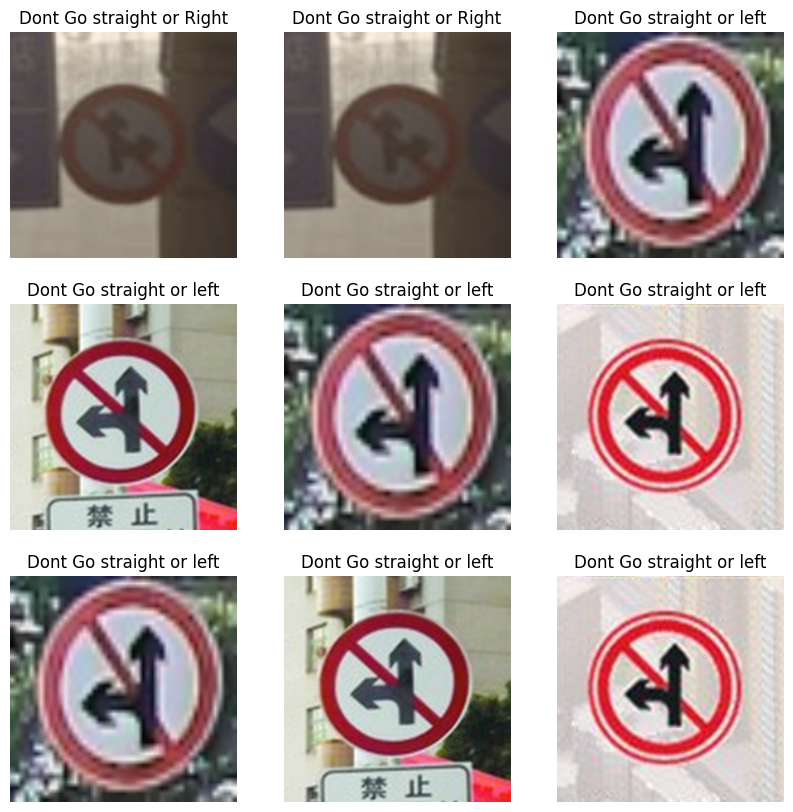

In [15]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
plt.show()

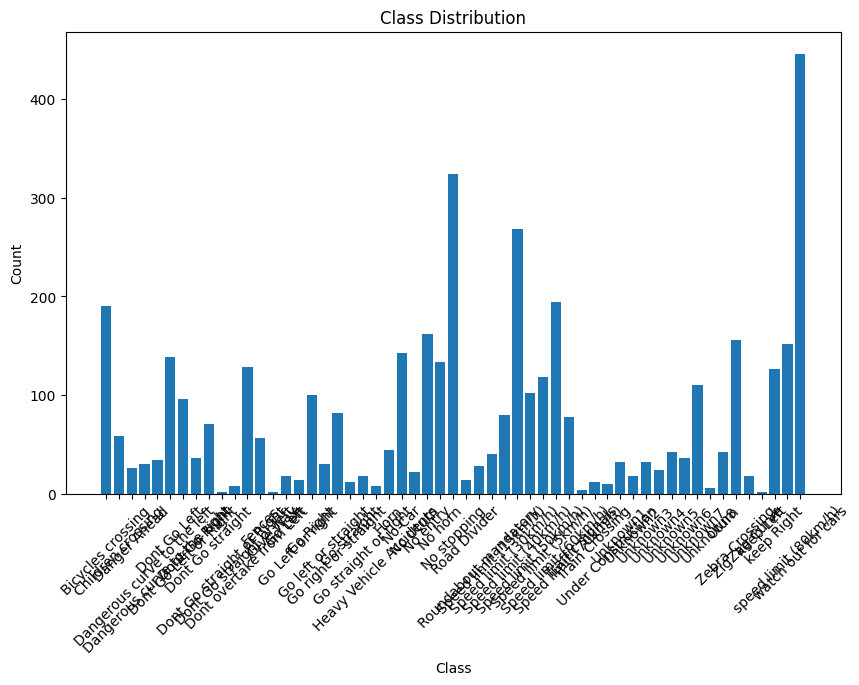

In [17]:
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [18]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


16705208/16705208 [==============================] - 0s 0us/step


In [19]:

for layer in base_model.layers:
    layer.trainable = False

In [20]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(len(unique_labels), activation='softmax')(x)


In [21]:
efficient_model = Model(inputs=base_model.input, outputs=output)
efficient_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
efficient_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [23]:
checkpoint_path = "efficient_model_weights.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_best_only=True,
                                      save_weights_only=True,
                                      mode='min',
                                      save_freq='epoch')

In [24]:
X_resized = np.array(resized_images)
X_train_resized, X_test_resized, y_train, y_test = train_test_split(X_resized, labels, test_size=0.2, random_state=42)


In [25]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [26]:
history = efficient_model.fit(X_train_resized, y_train_encoded,
                               epochs=10,
                               batch_size=32,
                               validation_data=(X_test_resized, y_test_encoded),
                               callbacks=[checkpoint_callback])

Epoch 1/10
105/105 [==============================] - ETA: 0s - loss: 1.3893 - accuracy: 0.6618
Epoch 1: val_loss improved from inf to 0.52876, saving model to efficient_model_weights.h5
105/105 [==============================] - 400s 4s/step - loss: 1.3893 - accuracy: 0.6618 - val_loss: 0.5288 - val_accuracy: 0.8802
Epoch 2/10
105/105 [==============================] - ETA: 0s - loss: 0.3403 - accuracy: 0.9245
Epoch 2: val_loss improved from 0.52876 to 0.23193, saving model to efficient_model_weights.h5
105/105 [==============================] - 377s 4s/step - loss: 0.3403 - accuracy: 0.9245 - val_loss: 0.2319 - val_accuracy: 0.9425
Epoch 3/10
105/105 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9652
Epoch 3: val_loss improved from 0.23193 to 0.12326, saving model to efficient_model_weights.h5
105/105 [==============================] - 367s 4s/step - loss: 0.1637 - accuracy: 0.9652 - val_loss: 0.1233 - val_accuracy: 0.9653
Epoch 4/10
105/105 [===============

In [27]:
test_loss, test_acc = efficient_model.evaluate(X_test_resized, y_test_encoded)
print("Test Accuracy:", test_acc)

27/27 [==============================] - 75s 3s/step - loss: 0.0504 - accuracy: 0.9880
Test Accuracy: 0.9880239367485046


In [28]:
layer_outputs = [layer.output for layer in efficient_model.layers]
activation_model = Model(inputs=efficient_model.input, outputs=layer_outputs)
sample_image = X_train_resized[0:1]
activations = activation_model.predict(sample_image)

1/1 [==============================] - 4s 4s/step


In [32]:
# Define the maximum number of images to display for each layer
max_images = 3

# Loop through each layer and its corresponding activation
for layer_name, activation in zip(efficient_model.layers, activations):
    print(layer_name.name, activation.shape)
    if len(activation.shape) == 4:  # Check if the activation is of shape (batch_size, height, width, channels)
        # Create a row of subplots
        num_channels = min(activation.shape[-1], max_images)
        fig, axes = plt.subplots(1, num_channels, figsize=(15, 2))
        fig.suptitle(layer_name.name)

        # Visualize each channel in a subplot
        for i in range(num_channels):
            axes[i].imshow(activation[0, :, :, i], cmap='viridis')
            axes[i].axis('off')

        plt.show()


Output hidden; open in https://colab.research.google.com to view.

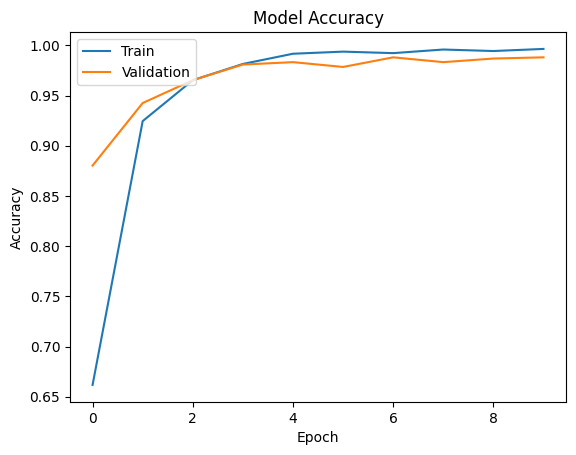

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


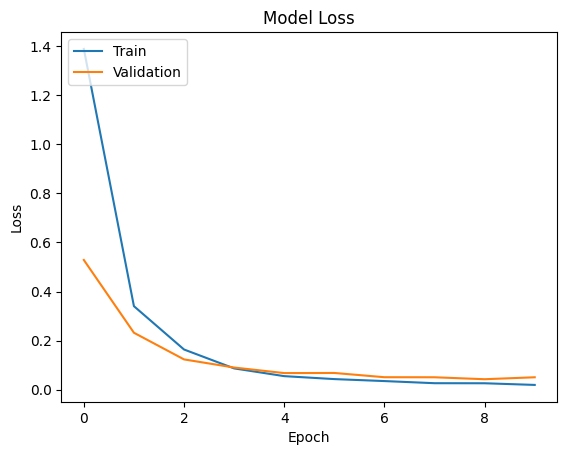

In [34]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


27/27 [==============================] - 73s 3s/step


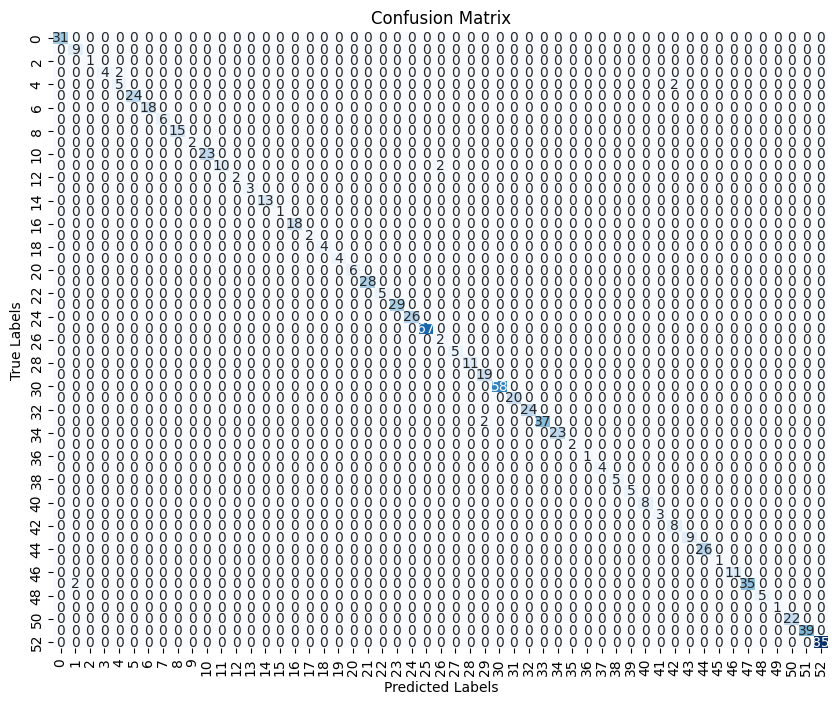

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       0.82      1.00      0.90         9
           2       1.00      1.00      1.00         1
           3       1.00      0.67      0.80         6
           4       0.71      0.71      0.71         7
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        18
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00        15
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00        23
          12       1.00      0.83      0.91        12
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00        13
          17       1.00      1.00      1.00         1
          18       1.00      1.00      1.00        18
          19       1.00    

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict labels for the test data
y_pred = efficient_model.predict(X_test_resized)
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_test_encoded, y_pred_labels))


1/1 [==============================] - 0s 158ms/step


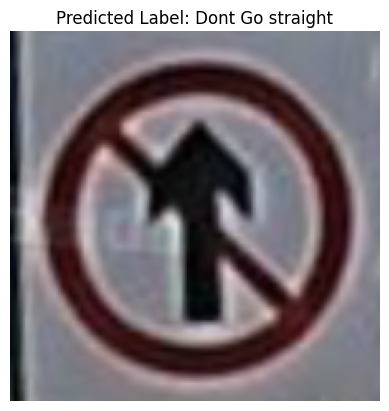

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
image_path = '/content/drive/MyDrive/DL/traffic_Data/TEST/010_0018_j.png'  # Provide the path to your image
input_image = cv2.imread(image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
input_image = cv2.resize(input_image, (224, 224))  # Resize to match model input size
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

# Predict the label
prediction = efficient_model.predict(input_image)
predicted_label = np.argmax(prediction)

# Decode the predicted label
predicted_class = label_encoder.inverse_transform([predicted_label])

# Display the image along with its predicted label
plt.imshow(input_image[0])
plt.title(f'Predicted Label: {predicted_class[0]}')
plt.axis('off')
plt.show()
